### **Importing**

In [33]:
import os
import math
from matplotlib import pyplot as plt
import torch
import gpytorch
from gpytorch import kernels, means, models, mlls, settings
from gpytorch import distributions as distr
from tqdm import tqdm

### **Note**
#### Run Bayesian Optimization in this order: 
GP Model $\rightarrow$ Training Data $\rightarrow$ Setup and Training $\rightarrow$ Visualize $\rightarrow$ Optimization based on uncertainty $\rightarrow$ **Setup and Training (Start loop)** $\rightarrow$ Visualize ...
###### ***
Also this is a bugged version, will upload modified version afterwards!

### **GP Model**

In [34]:
class GPmodel(models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super().__init__(train_inputs, train_targets, likelihood)
        self.constraint = gpytorch.constraints.GreaterThan(0.05)
        self.mean_module = means.ConstantMean()
        self.covar_module = kernels.ScaleKernel(kernels.RBFKernel(lengthscale_constraint=self.constraint))
        # self.linear_layers = Linear_layers(, 1)
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return distr.MultivariateNormal(mean_x, covar_x)


### **Training Data**

In [35]:
# train_x = torch.linspace(0, 1, 10)
train_x = torch.rand(8)
train_y = torch.sin(train_x*(2*math.pi))+torch.randn(train_x.size())*0.1
test_x = torch.linspace(0,1,101)
std_y = torch.sin(test_x*(2*math.pi))

### **Setup and Training**

In [36]:
# noise = torch.randn_like(train_x)/100
noise = torch.zeros_like(train_x)
# print(noise)
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise = noise, dtype=torch.float32)
model = GPmodel(train_x, train_y, likelihood)
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = mlls.ExactMarginalLogLikelihood(likelihood, model)
epochs = 50
for i in tqdm(range(epochs)):
    optimizer.zero_grad()
    output = model(train_x)
    # print(output, train_y)
    loss = -mll(output, train_y)
    # print(loss)
    loss.backward()
    if i % 5 == 4:
        print('Iter: %d/%d  Loss: %.3f  Lengthscale: %.3f'%(i+1, epochs, loss.item(), model.covar_module.base_kernel.lengthscale.item()))
    optimizer.step()
    

100%|██████████| 50/50 [00:00<00:00, 249.82it/s]

Iter: 5/50  Loss: 15.558  Lengthscale: 0.569
Iter: 10/50  Loss: 4.270  Lengthscale: 0.431
Iter: 15/50  Loss: 1.366  Lengthscale: 0.351
Iter: 20/50  Loss: 0.752  Lengthscale: 0.305
Iter: 25/50  Loss: 0.564  Lengthscale: 0.278
Iter: 30/50  Loss: 0.466  Lengthscale: 0.262
Iter: 35/50  Loss: 0.402  Lengthscale: 0.251
Iter: 40/50  Loss: 0.350  Lengthscale: 0.243
Iter: 45/50  Loss: 0.313  Lengthscale: 0.238
Iter: 50/50  Loss: 0.290  Lengthscale: 0.234


### **Visualize**

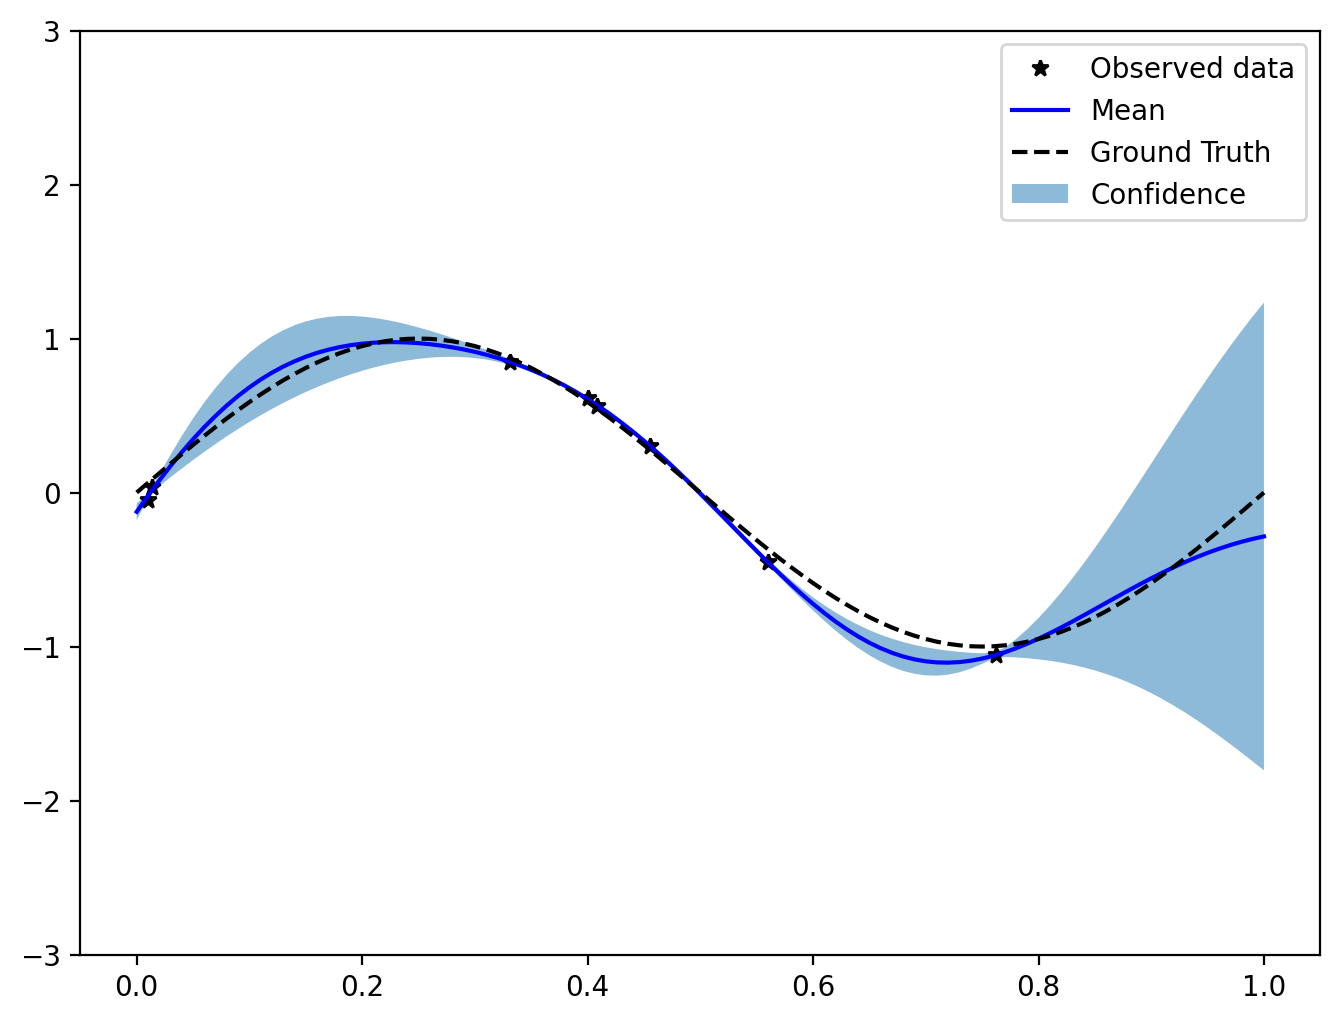

In [37]:
model.eval()
likelihood.eval()
with torch.no_grad(), settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize = (8, 6), dpi=200)
    lower, upper = observed_pred.confidence_region()
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    ax.plot(test_x.numpy(), std_y.numpy(), 'k', linestyle='dashed')
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha = 0.5)
    ax.set_ylim([-3,3])
    ax.legend(['Observed data', 'Mean', 'Ground Truth', 'Confidence'])
plt.show()

### **Optimization based on uncertainty**

In [34]:
diff = torch.tensor([upper[i]-lower[i] for i in range(len(test_x))])
max_diff, max_diff_idx = torch.topk(diff, 1)
max_diff_idx = int(max_diff_idx)
new_train_x = list(train_x)
new_train_x.append(max_diff_idx*1/100)
train_x = torch.tensor(new_train_x, dtype=torch.float32)
train_y = torch.sin(train_x*(2*math.pi))+torch.randn(train_x.size())*0.1


In [49]:
1/10

0.1

In [2]:
torch.rand(8)

tensor([0.1355, 0.5061, 0.1454, 0.5048, 0.6666, 0.1906, 0.6449, 0.6546])